# Investigating stylized facts of asset returns

1- Import the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as scs
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import yfinance as yf

2- Download the S&P 500 data

In [2]:
df = yf.download('^GSPC', start='2000-01-01', end='2023-12-31', progress=False)

2- Calculate the returns

In [3]:
df = df[['Adj Close']].rename(columns={'Adj Close':'adj_close'})
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1))
df = df[['adj_close', 'log_rtn']].dropna(how='any')

#### Fact 1 - Non-Gaussian distribution returns

1- Calculate the normal PDF using the mean and standard deviation of the observed returns

In [4]:
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

2- Plot the histogram and the Q-Q Plot

C:\Users\Marqu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


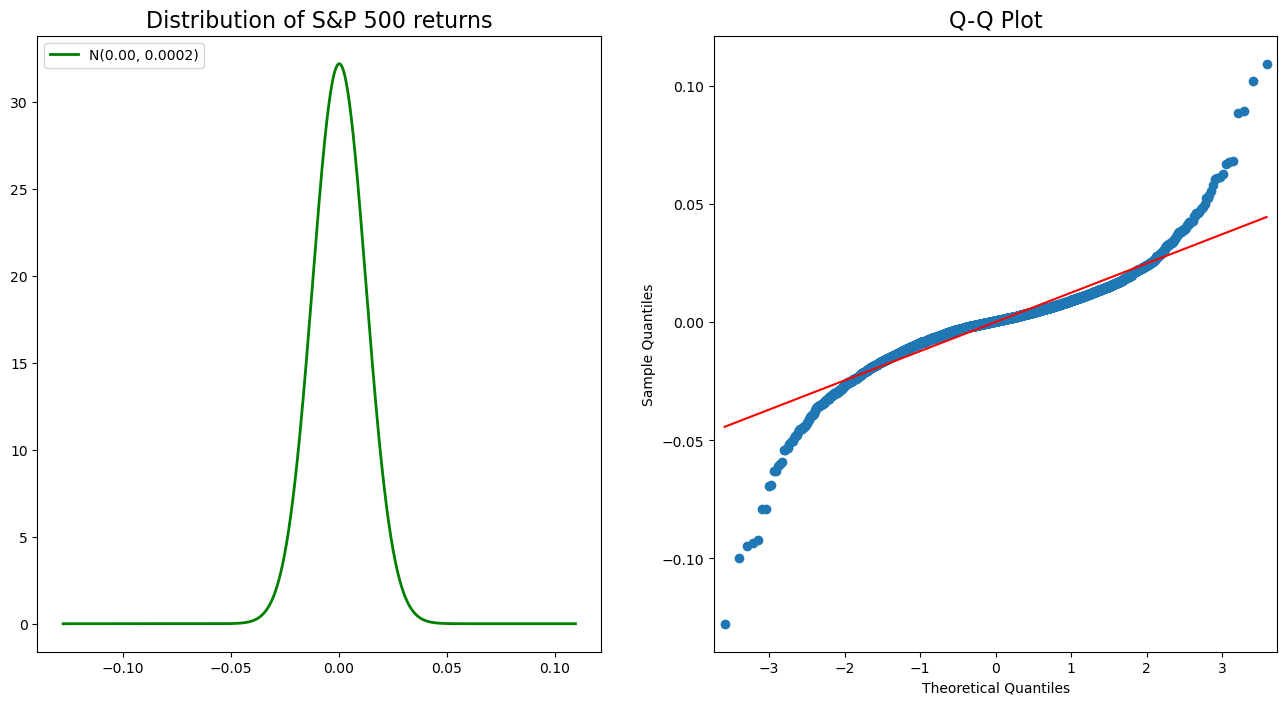

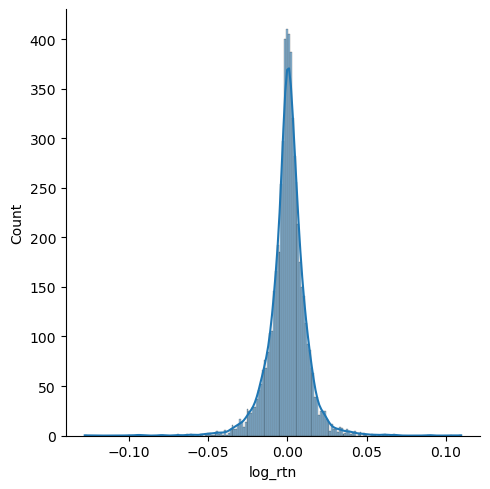

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Histogram
sns.displot(data=df.log_rtn, kde=True)
ax[0].set_title('Distribution of S&P 500 returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left')

# Q-Q Plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q Plot', fontsize=16)

# Show
plt.show()

3- Print the summary statistics of the log returns

In [6]:
jb_test = scs.jarque_bera(df.log_rtn.values)

print('{:-^50s}'.format(' Descriptive Statitics '))
print(f'Range of dates: {min(df.index.date)} - {max(df.index.date)}')
print(f'Number of observations: {df.shape[0]}')
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}')
print(f'Jarque-Bera Statistic: {jb_test[0]:.2f} with p-value {jb_test[1]:.2f}')

------------- Descriptive Statitics --------------
Range of dates: 2000-01-04 - 2023-12-29
Number of observations: 6036
Mean: 0.0002
Median: 0.0006
Min: -0.1277
Max: 0.1096
Standard Deviation: 0.0124
Skewness: -0.3784
Kurtosis: 10.2834
Jarque-Bera Statistic: 26690.69 with p-value 0.00


### Fact 2 - Volatility Clustering

1- Run the following code to visualize the log returns series

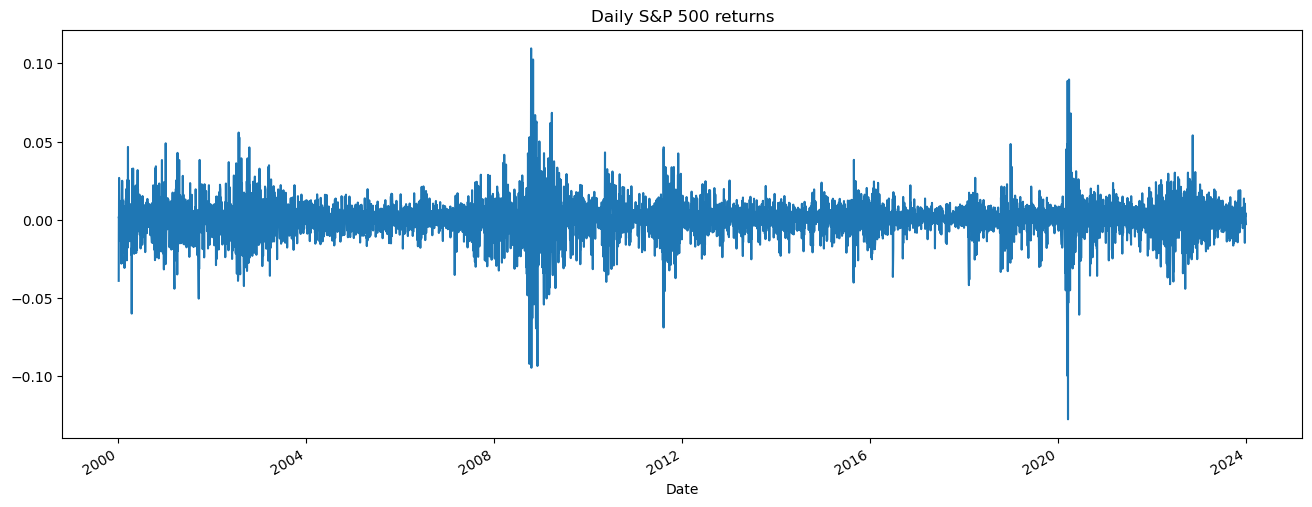

In [7]:
df.log_rtn.plot(title='Daily S&P 500 returns', figsize=(16,6))

# Show
plt.show()

### Fact 3 - Absence of Autocorrelation in returns

1- Define the parameters for creating the Autocorrelation plot

In [8]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

2- Run the following code to create `ACF (AutoCorrelation Function)` plot of log returns

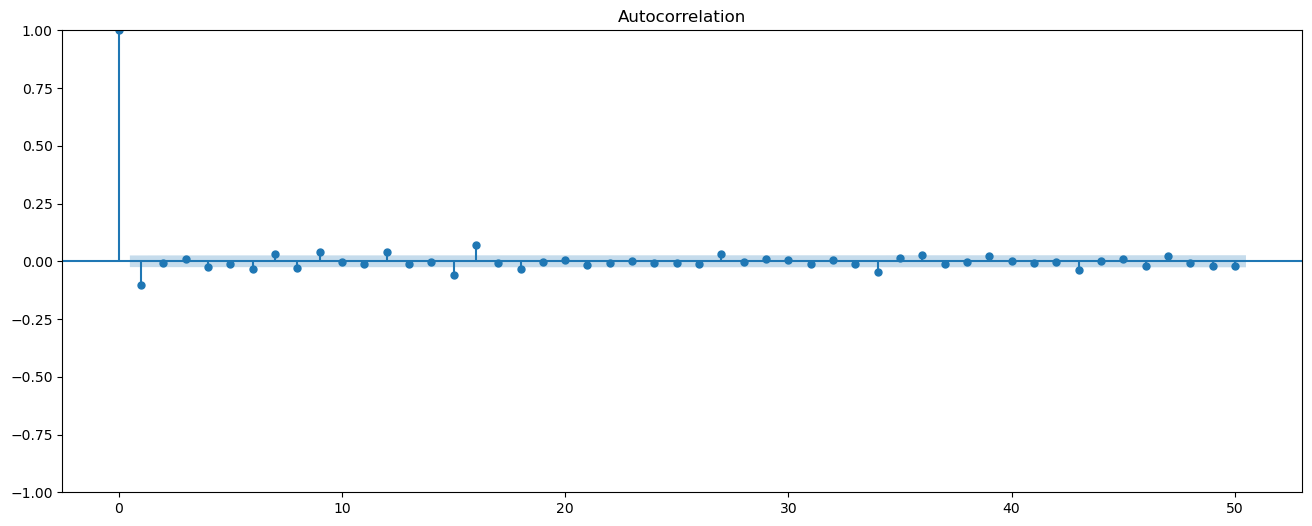

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))
acf = smt.graphics.plot_acf(df.log_rtn, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax)

# Show
plt.show()

### 4 - Small and Decreasing Autocorrelation in `square/absolute` returns

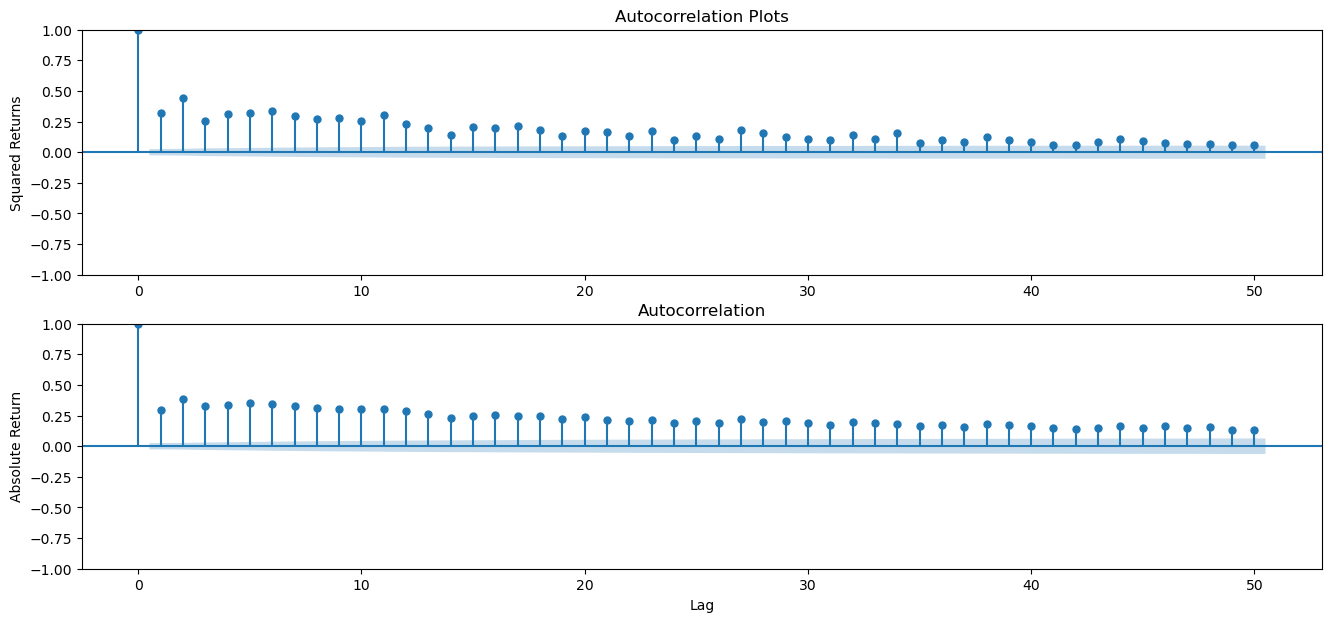

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(16,7))

smt.graphics.plot_acf(df.log_rtn**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Autocorrelation Plots', ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Absolute Return', xlabel='Lag')

# Show
plt.show()

### Fact 5 - Leverage Effect

1- Calculate volatility measures as moving standard deviations

In [11]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()  

2- Plot all the series

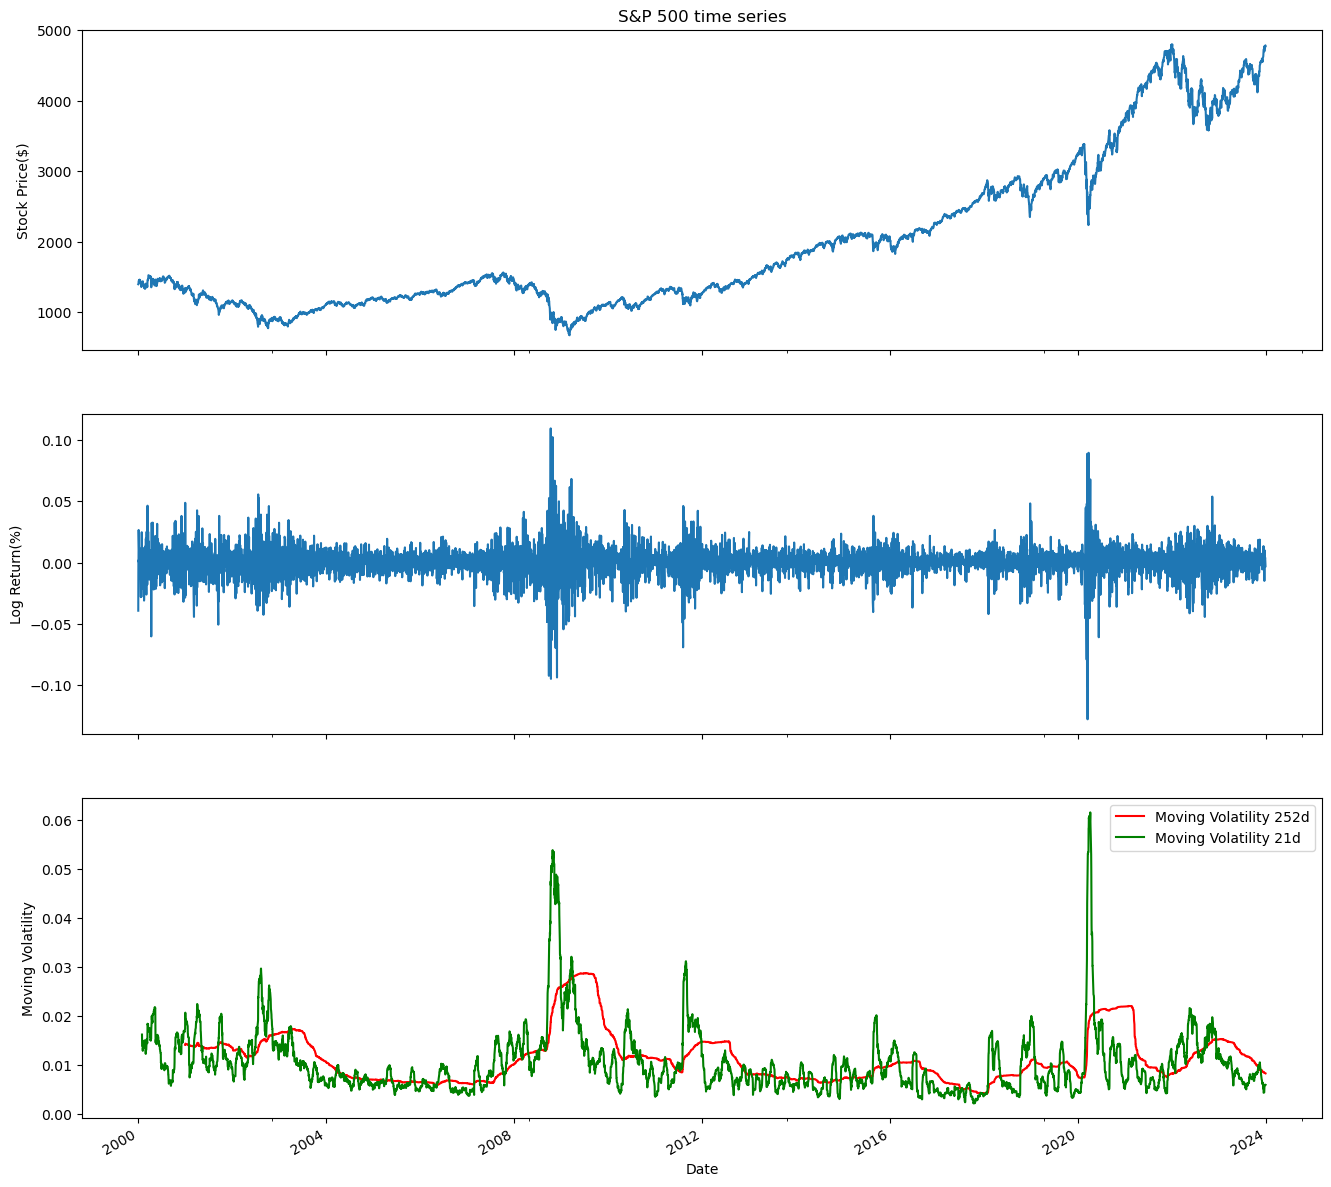

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(16,16), sharex=True)

df.adj_close.plot(ax=ax[0])
ax[0].set(title='S&P 500 time series', ylabel='Stock Price($)')

df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Log Return(%)')

df.moving_std_252.plot(ax=ax[2], color='r', label='Moving Volatility 252d')
df.moving_std_21.plot(ax=ax[2], color='g', label='Moving Volatility 21d')
ax[2].set(ylabel='Moving Volatility', xlabel='Date')
ax[2].legend()

# Show
plt.show()

### There's More

1- Download and preprocess the prices of `S&P 500` and `VIX`

In [13]:
# Download Data
sv = yf.download(['^GSPC', "^VIX"], start='2000-01-01', end='2023-12-31', progress=False)

# Preprocess
sv = sv[['Adj Close']]
sv.columns = sv.columns.droplevel(0)
sv = sv.rename(columns={'^GSPC':'SP500', '^VIX':'VIX'})

2- Calculate log returns

In [14]:
sv['log_rtn'] = np.log(sv.SP500 / sv.SP500.shift(1))
sv['vol_rtn'] = np.log(sv.VIX / sv.VIX.shift(1))
sv.dropna(how='any', axis=0, inplace=True)

3- Plot a scatterplot with the returns on the axes and fit a regression line to identify trend

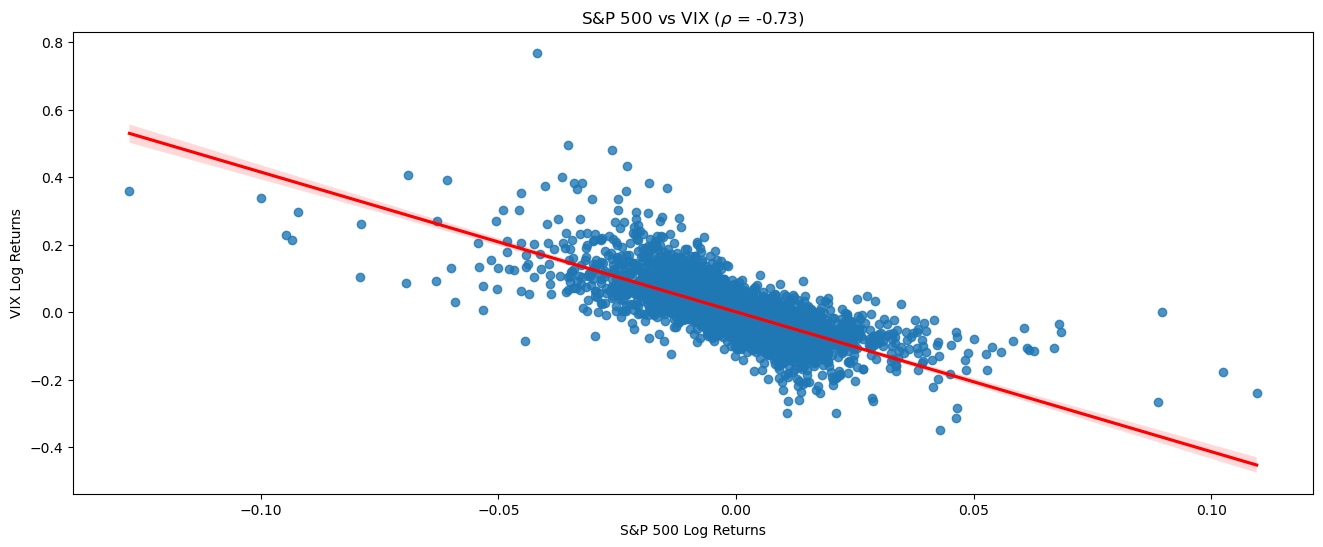

In [15]:
fig, ax = plt.subplots(figsize=(16,6))

corr_coeff = sv.log_rtn.corr(sv.vol_rtn)

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=sv, line_kws={'color':'red'})
ax.set(title=f'S&P 500 vs VIX ($\\rho$ = {corr_coeff:.2f})', ylabel='VIX Log Returns', xlabel='S&P 500 Log Returns')

# Show
plt.show()